In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Step 1: Load the dataset
# Replace 'your_data.csv' with your actual file path
data = pd.read_excel('/kaggle/input/catboostregressor/Data for Item Proposal_Regional-1.xlsx', sheet_name="Raw Data")

# Clean column names
data.columns = data.columns.str.replace(' ', "_")

# Preprocess: Handle 'Month' column if it's datetime
if pd.api.types.is_datetime64_any_dtype(data['Month']):
    data['Month_Number'] = pd.to_datetime(data['Month']).dt.month
    data['Year'] = pd.to_datetime(data['Month']).dt.year
    data = data.drop('Month', axis=1)
else:
    print("Month is not datetime, treating as categorical")

# Features and target
X = data.drop(['Net_Sales', 'Item_Name', 'Item_Code'], axis=1)
y = data['Net_Sales']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()

print(f"\nCategorical Features: {categorical_cols}")
print(f"Numerical Features: {numerical_cols}")


Categorical Features: ['Zone_Name', 'Depot', 'Category']
Numerical Features: ['Unit_Price', 'Sales', 'Sales_Qty', 'Net_Discount', 'Month_Number', 'Year']


In [3]:
# --- CatBoost handles categorical features natively, so we don't need to dummy encode or target encode ---
# But we must pass categorical column indices to the model

# Step 2: Split data first to avoid data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reset index for safe alignment
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Get list of categorical feature indices
cat_features = [i for i, col in enumerate(X_train.columns) if col in categorical_cols]

print(f"Categorical column indices for CatBoost: {cat_features}")
print(f"Categorical columns: {categorical_cols}")

# Step 3: Model Training with CatBoost
print("\nTraining CatBoost Regressor...")
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.1,
    depth=8,
    loss_function='RMSE',
    eval_metric='MAE',
    random_seed=42,
    verbose=100,
    cat_features=cat_features,
    early_stopping_rounds=50
)

# Fit model
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, plot=False)

Categorical column indices for CatBoost: [0, 1, 2]
Categorical columns: ['Zone_Name', 'Depot', 'Category']

Training CatBoost Regressor...
0:	learn: 27553.3559609	test: 28187.4359711	best: 28187.4359711 (0)	total: 90.3ms	remaining: 45s
100:	learn: 1759.8464014	test: 1887.6467340	best: 1887.6467340 (100)	total: 1.85s	remaining: 7.32s
200:	learn: 922.9658587	test: 1169.4519385	best: 1169.4519385 (200)	total: 3.46s	remaining: 5.14s
300:	learn: 622.9296630	test: 946.6009094	best: 946.4541638 (299)	total: 5.24s	remaining: 3.46s
400:	learn: 464.3686839	test: 831.9830736	best: 831.9830736 (400)	total: 6.99s	remaining: 1.73s
499:	learn: 375.0717123	test: 762.2247225	best: 762.2247225 (499)	total: 8.64s	remaining: 0us

bestTest = 762.2247225
bestIteration = 499



In [4]:
# Step 4: Predictions
predictions = model.predict(X_test)


In [5]:
# Step 5: Evaluation Metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / (y_test + 1e-8))) * 100  # Avoid division by zero

# Adjusted R²
n = len(y_test)
p = X_train.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [6]:
print("\n=== Model Performance Metrics ===")
print(f"Mean Absolute Error (MAE): {mae:,.2f}")
print(f"Mean Squared Error (MSE): {mse:,.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


=== Model Performance Metrics ===
Mean Absolute Error (MAE): 762.22
Mean Squared Error (MSE): 47,116,264.71
Root Mean Squared Error (RMSE): 6,864.13
R² Score: 0.9924
Adjusted R²: 0.9924
Mean Absolute Percentage Error (MAPE): 3.22%


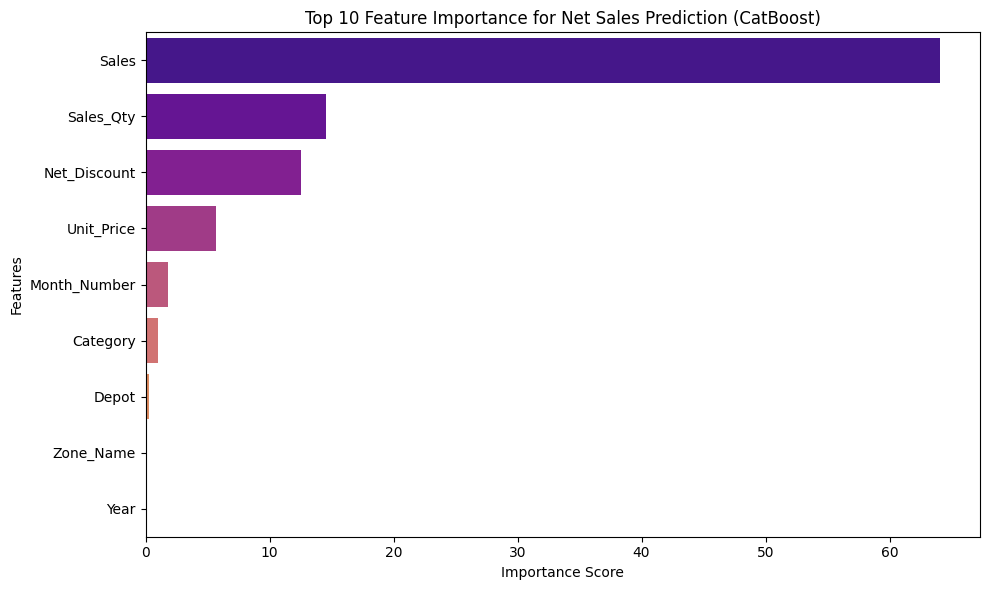

In [7]:
# 1. Feature Importance Plot
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.get_feature_importance()
})
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='plasma')
plt.title('Top 10 Feature Importance for Net Sales Prediction (CatBoost)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()


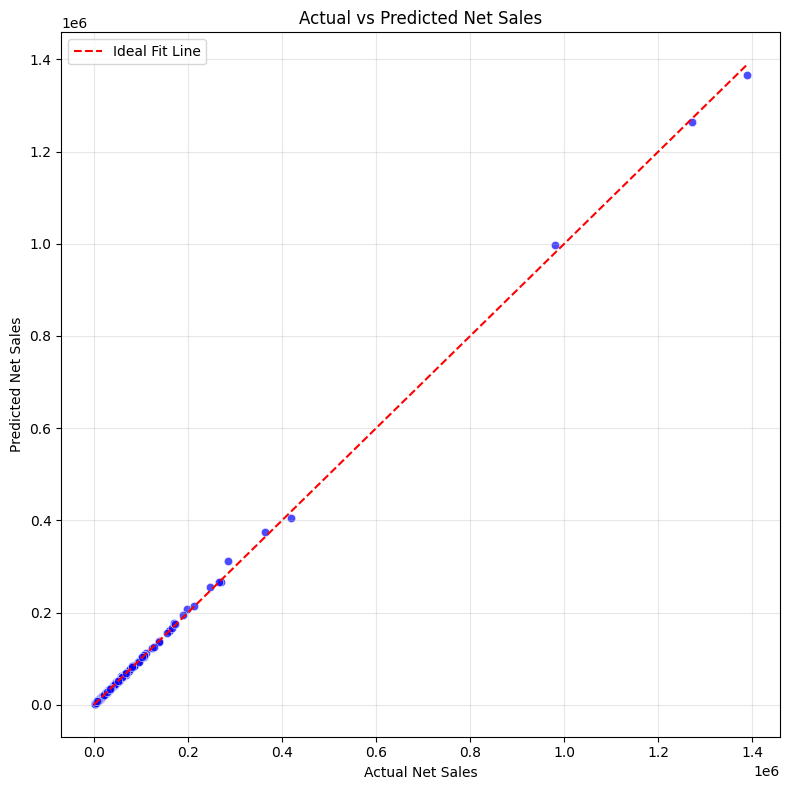

In [8]:
# 2. Actual vs. Predicted Sales Plot
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}).sample(500, random_state=42)
max_val = max(comparison_df['Actual'].max(), comparison_df['Predicted'].max())

plt.figure(figsize=(8, 8))
sns.scatterplot(x='Actual', y='Predicted', data=comparison_df, color='blue', alpha=0.7)
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='Ideal Fit Line')
plt.title('Actual vs Predicted Net Sales')
plt.xlabel('Actual Net Sales')
plt.ylabel('Predicted Net Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

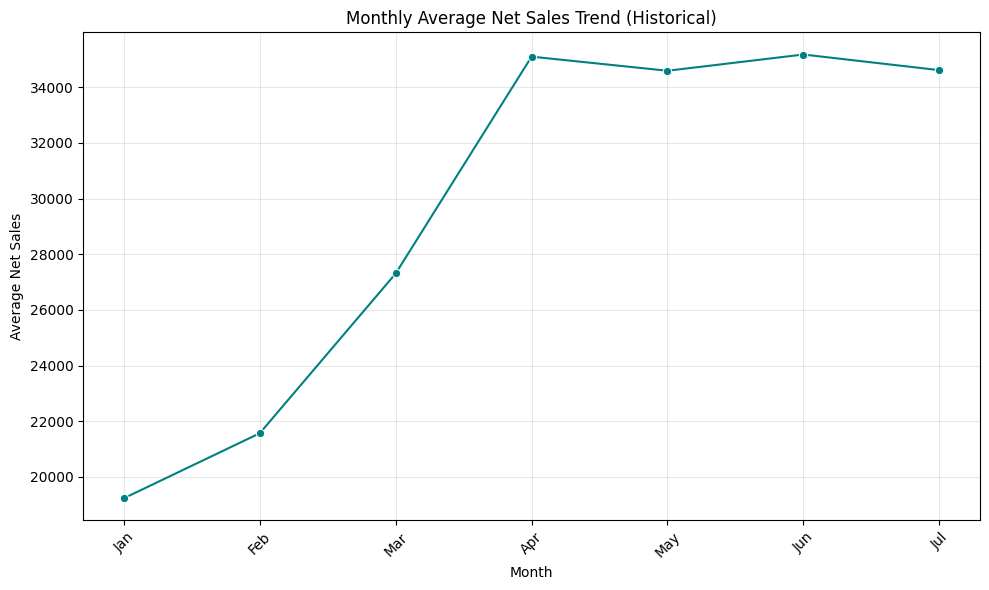

In [9]:
# 3. Monthly Sales Trend Plot (from original data)
if 'Month_Number' in data.columns:
    monthly_sales = data.groupby('Month_Number')['Net_Sales'].mean().reset_index()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    monthly_sales['Month_Name'] = monthly_sales['Month_Number'].map(lambda x: month_names[x-1])

    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Month_Name', y='Net_Sales', data=monthly_sales, marker='o', color='teal')
    plt.title('Monthly Average Net Sales Trend (Historical)')
    plt.xlabel('Month')
    plt.ylabel('Average Net Sales')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [11]:
# --- Error Analysis ---

# Calculate errors
errors = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions,
    'Absolute_Error': np.abs(y_test - predictions),
    'Percentage_Error': np.abs((y_test - predictions) / (y_test + 1e-8)) * 100
})


In [12]:
# Option 1: Filter by absolute error threshold
threshold = np.percentile(y_test, 75) * 0.1  # e.g., 10% of 75th percentile of sales
large_deviations = errors[errors['Absolute_Error'] > threshold]
print(f"\nData points with Absolute Error > {threshold:.2f}:")
print(large_deviations.sort_values(by='Absolute_Error', ascending=False).head(10))

# Option 2: Top 5% largest errors
error_95th = errors['Absolute_Error'].quantile(0.95)
top_5_percent_errors = errors[errors['Absolute_Error'] > error_95th]
print(f"\nTop 5% Deviated Data Points (Absolute Error > {error_95th:.2f}):")
print(top_5_percent_errors.sort_values(by='Absolute_Error', ascending=False).head(10))

# Optional: Merge with test features for context
X_test_with_errors = X_test.copy()
X_test_with_errors.reset_index(drop=True, inplace=True)
errors_with_features = pd.concat([errors, X_test_with_errors], axis=1)
print("\nTop Deviated Predictions with Feature Context:")
print(errors_with_features.loc[errors_with_features['Absolute_Error'] > error_95th] \
      .sort_values('Absolute_Error', ascending=False)[['Actual', 'Predicted', 'Absolute_Error', 'Zone_Name', 'Depot', 'Unit_Price', 'Sales_Qty']])





Data points with Absolute Error > 2604.00:
         Actual     Predicted  Absolute_Error  Percentage_Error
1237   793872.0  1.095200e+06   301327.534233         37.956690
583   1148198.0  1.262261e+06   114062.567964          9.934050
449   1159935.0  1.226844e+06    66909.489240          5.768383
1070  1070324.0  1.021761e+06    48562.749718          4.537201
669    448128.0  4.088638e+05    39264.214550          8.761830
650    286000.0  3.119023e+05    25902.331148          9.056759
252   1389197.0  1.365347e+06    23850.162324          1.716831
302    337761.0  3.588505e+05    21089.476515          6.243905
1609   980294.0  9.976111e+05    17317.065061          1.766517
86    1244160.0  1.258330e+06    14169.659003          1.138894

Top 5% Deviated Data Points (Absolute Error > 1724.15):
         Actual     Predicted  Absolute_Error  Percentage_Error
1237   793872.0  1.095200e+06   301327.534233         37.956690
583   1148198.0  1.262261e+06   114062.567964          9.934050
449

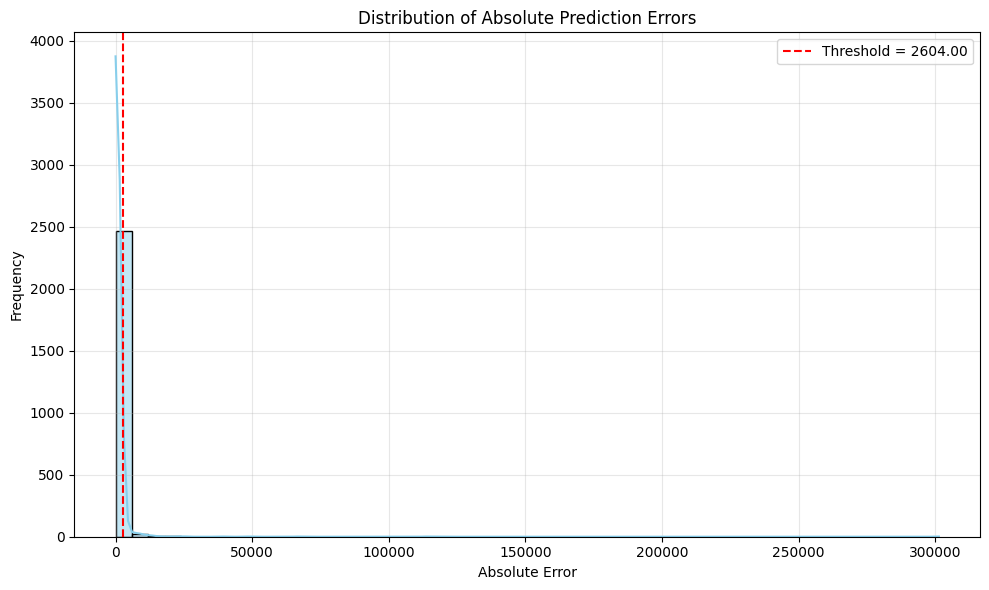

In [13]:
# Histogram of Absolute Errors
plt.figure(figsize=(10, 6))
sns.histplot(errors['Absolute_Error'], bins=50, kde=True, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.2f}')
plt.title('Distribution of Absolute Prediction Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [14]:
# Step: Percentage of predictions within acceptable error margin
mean_sales = y_test.mean()
acceptable_error = 0.1 * mean_sales  # 10% of average sales
within_range = errors[errors['Absolute_Error'] <= acceptable_error]
accuracy_within_range = (len(within_range) / len(errors)) * 100


In [15]:
print(f"\nAverage Net Sales: {mean_sales:,.2f}")
print(f"Acceptable error threshold (10%): {acceptable_error:,.2f}")
print(f"Number of predictions within ±{acceptable_error:,.2f}: {len(within_range)} out of {len(errors)}")
print(f"Percentage of predictions within acceptable range: {accuracy_within_range:.2f}%")


Average Net Sales: 29,982.98
Acceptable error threshold (10%): 2,998.30
Number of predictions within ±2,998.30: 2441 out of 2505
Percentage of predictions within acceptable range: 97.45%
